# L3 - Memory Optimization Techniques for ColPali

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

The following cell is not in the video and just ensures output later in this notebook will render properly.

In [1]:
import plotly.io as pio
pio.renderers.default = "notebook"

In [2]:
LOAD_PRECOMPUTED = True

#### Loading ColPali

In [3]:
from colpali_engine.models import ColPaliProcessor

model_name = "vidore/colpali-v1.3"
processor = ColPaliProcessor.from_pretrained(model_name)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/423 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

#### Loading Image Embedding Vectors

In [4]:
from helper import load_sample_image_embeddings

# Load or compute image embeddings using helper function
# that only loads a sample of data
images_df = load_sample_image_embeddings(
    load_precomputed=LOAD_PRECOMPUTED,
)

# Display some random entries
sample_df = images_df.sample(n=3, random_state=42)
sample_df

,image_path,image_embedding
83,ro_shared_data/pdfs/screenshots/AI4E_W3-page-0...,"[[-0.03662109375, 0.17578125, 0.1142578125, 0...."
53,ro_shared_data/pdfs/screenshots/AI4E_W2-page-0...,"[[-0.1455078125, -0.09130859375, 0.1591796875,..."
70,ro_shared_data/pdfs/screenshots/AI4E_W2-page-0...,"[[-0.0458984375, 0.16015625, 0.1708984375, 0.0..."


#### Displaying Sample Images from the Collection and their Embedding Vectors

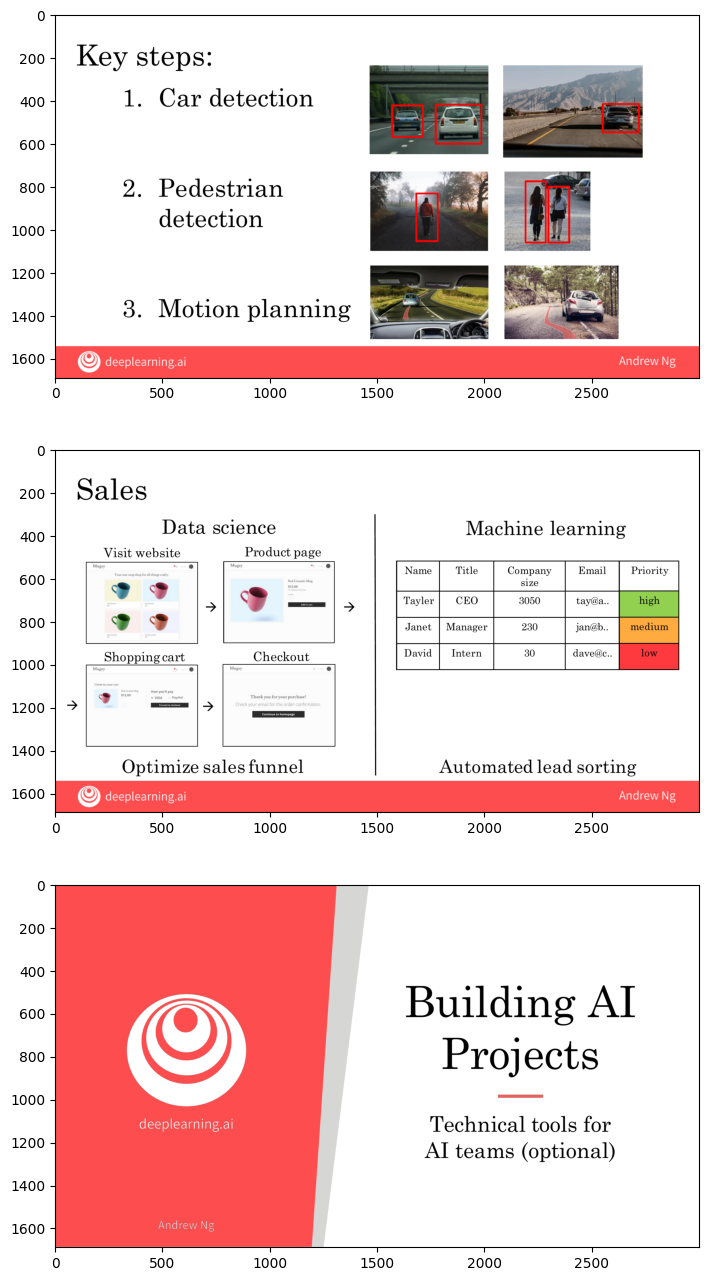

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axarr = plt.subplots(3, 1, figsize=(9, 16))
for i, (_, row) in enumerate(sample_df.iterrows()):
    image = Image.open(row["image_path"])
    axarr[i].imshow(image.convert("RGB"))

In [6]:
images_df["original_shape"] = images_df["image_embedding"].apply(
    lambda x: x.shape
)
images_df.sample(n=5)

,image_path,image_embedding,original_shape
62,ro_shared_data/pdfs/screenshots/AI4E_W2-page-0...,"[[-0.033203125, 0.166015625, 0.162109375, 0.04...","(1031, 128)"
99,ro_shared_data/pdfs/screenshots/AI4E_W3-page-0...,"[[-0.03662109375, 0.154296875, 0.171875, 0.055...","(1031, 128)"
2,ro_shared_data/pdfs/screenshots/AI4E_W1-page-0...,"[[-0.1240234375, -0.025634765625, 0.0668945312...","(1031, 128)"
22,ro_shared_data/pdfs/screenshots/AI4E_W1-page-0...,"[[0.00144195556640625, 0.0400390625, 0.078125,...","(1031, 128)"
49,ro_shared_data/pdfs/screenshots/AI4E_W2-page-0...,"[[-0.000621795654296875, 0.008056640625, 0.079...","(1031, 128)"


#### Performing Vector Quantization

In [7]:
import numpy as np

# Perform bucketing
min_value, max_value = -0.8, 1.2
value_space = np.linspace(min_value, max_value, 256)

# Find which bucket index the target value belongs to
target_value = 0.2
bucket_index = np.argmin(np.abs(value_space - target_value))
bucket_index

128

In [8]:
simple_vector = 2 * np.random.random(16) - 1.0
binary_vector = (simple_vector > 0).astype(int)
print(simple_vector, "->", binary_vector)

[ 0.82271984  0.74804333 -0.0024267   0.87696705  0.80394115  0.50450583
  0.78138577 -0.42777904 -0.75489074  0.558592    0.44307136 -0.47367532
 -0.85441414  0.40561948  0.61983951 -0.56559173] -> [1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0]


#### Displaying a Sample Image's Tokens and Embedding Vectors

In [9]:
image = Image.open(images_df["image_path"][0])
batch_images = processor.process_images([image])
processor.decode(batch_images.input_ids[0])

'<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><imag

In [10]:
image_mask = processor.get_image_mask(batch_images)[0]
images_df["image_embedding"][0][image_mask]

array([[-0.15332031,  0.03051758,  0.13574219, ...,  0.01989746,
        -0.13671875,  0.13769531],
       [-0.23730469, -0.01940918,  0.18164062, ..., -0.03295898,
        -0.08496094,  0.02905273],
       [-0.16894531,  0.0378418 ,  0.12060547, ..., -0.00588989,
        -0.14355469,  0.17480469],
       ...,
       [-0.11572266, -0.03173828,  0.14257812, ..., -0.04125977,
        -0.10986328,  0.10546875],
       [ 0.00848389,  0.13671875,  0.13476562, ..., -0.01519775,
        -0.19824219, -0.07421875],
       [ 0.02307129,  0.15136719,  0.13769531, ..., -0.01708984,
        -0.20019531, -0.08007812]])

In [11]:
patch_size = 32  # the default Colpali patch size
model_dim = 128  # the default Colpali embedding size


def embeddings_grid(image_embeddings: np.ndarray):
    """
    Reshape the image embeddings so we have a grid of patches
    and their corresponding embeddings.
    """
    return image_embeddings.reshape((patch_size, patch_size, model_dim))

In [12]:
grid = embeddings_grid(images_df["image_embedding"][0][image_mask])
grid

array([[[-1.53320312e-01,  3.05175781e-02,  1.35742188e-01, ...,
          1.98974609e-02, -1.36718750e-01,  1.37695312e-01],
        [-2.37304688e-01, -1.94091797e-02,  1.81640625e-01, ...,
         -3.29589844e-02, -8.49609375e-02,  2.90527344e-02],
        [-1.68945312e-01,  3.78417969e-02,  1.20605469e-01, ...,
         -5.88989258e-03, -1.43554688e-01,  1.74804688e-01],
        ...,
        [-1.27929688e-01,  4.88281250e-02,  7.42187500e-02, ...,
          3.02734375e-02, -1.23046875e-01,  1.54296875e-01],
        [-1.30859375e-01,  5.07812500e-02,  7.27539062e-02, ...,
          3.32031250e-02, -1.26953125e-01,  1.59179688e-01],
        [-6.37054443e-04,  1.30859375e-01,  1.42578125e-01, ...,
         -1.92871094e-02, -1.96289062e-01, -7.03125000e-02]],

       [[-1.66992188e-01, -1.06445312e-01,  2.39257812e-02, ...,
         -3.49121094e-02, -1.16699219e-01, -2.38037109e-02],
        [-1.34765625e-01, -6.10351562e-02,  1.28936768e-03, ...,
         -2.00195312e-02, -3.27148438e

#### Performing Row and Column Pooling

In [13]:
def row_mean_pooling(grid_embeddings: np.ndarray) -> np.ndarray:
    return grid_embeddings.mean(axis=1)


def column_mean_pooling(grid_embeddings: np.ndarray) -> np.ndarray:
    return grid_embeddings.mean(axis=0)

In [14]:
row_mean_pooling(grid)

array([[-0.11473548,  0.01808548,  0.11580276, ..., -0.02144814,
        -0.10925579,  0.08829117],
       [-0.10799599,  0.0003705 ,  0.10084367, ..., -0.02790165,
        -0.09512949,  0.07151413],
       [-0.10912132, -0.04421937,  0.08473897, ..., -0.04862165,
        -0.05805779,  0.05914438],
       ...,
       [-0.18773079,  0.0231111 ,  0.10800266, ..., -0.01242846,
        -0.07014465,  0.00422668],
       [-0.13119507,  0.01645994,  0.10053253, ..., -0.0113048 ,
        -0.09478569,  0.06252974],
       [-0.08347129,  0.04847908,  0.08846283, ..., -0.00945055,
        -0.1164856 ,  0.03432846]])

In [15]:
column_mean_pooling(grid)

array([[-0.0590148 , -0.01817989,  0.05971336, ..., -0.04294181,
        -0.06677437,  0.05738664],
       [-0.09651375,  0.00392675,  0.09811139, ..., -0.03450537,
        -0.08097553,  0.03840065],
       [-0.10300028, -0.02036381,  0.09334087, ..., -0.03387809,
        -0.08960342,  0.10499001],
       ...,
       [-0.14610672,  0.00765795,  0.08983421, ..., -0.02006912,
        -0.09101677,  0.08463907],
       [-0.14072037,  0.00681981,  0.09446716, ..., -0.04786491,
        -0.08870387,  0.07546377],
       [-0.08451402, -0.0028832 ,  0.10643148, ..., -0.01567411,
        -0.07118273,  0.04536533]])

#### Performing Hierarchical Pooling

In [16]:
from colpali_engine.compression.token_pooling import (
    HierarchicalTokenPooler,
)

import numpy as np
import torch

pooler = HierarchicalTokenPooler()


def hierarchical_token_pooling(
    arr: np.ndarray, pool_factor: int = 2
) -> np.ndarray:
    """
    Apply hierarchical clustering to a single document embedding.
    """
    # Convert the array to 3D torch tensor
    arr_tensor = torch.from_numpy(arr[np.newaxis, :, :])

    # Apply hierarchical pooling
    pooled = pooler.pool_embeddings(arr_tensor, pool_factor=pool_factor)
    return pooled.cpu().detach().numpy()[0]

In [17]:
# Demonstrate on a single example
example_embedding = images_df["image_embedding"][0]
print(f"Original shape: {example_embedding.shape}")

# Apply hierarchical token pooling with pool_factor=2
pooled_embedding = hierarchical_token_pooling(
    example_embedding, pool_factor=2
)
print(f"Pooled shape: {pooled_embedding.shape}")

Original shape: (1031, 128)
Pooled shape: (515, 128)


#### Creating Qdrant Collection and Adding Vectors

In [18]:
from qdrant_client import QdrantClient, models

collection_name = "colpali-optimizations"

# Connect to Qdrant
client = QdrantClient("http://localhost:6333", timeout=120)

# Delete collection if it exists
if client.collection_exists(collection_name):
    client.delete_collection(collection_name)

In [19]:
client.create_collection(
    collection_name,
    vectors_config={
        "original": models.VectorParams(
            size=128,
            distance=models.Distance.DOT,
            multivector_config=models.MultiVectorConfig(
                comparator=models.MultiVectorComparator.MAX_SIM,
            ),
            hnsw_config=models.HnswConfigDiff(m=0),
            on_disk=True,
        ),
        "scalar_quantized": models.VectorParams(
            size=128,
            distance=models.Distance.DOT,
            multivector_config=models.MultiVectorConfig(
                comparator=models.MultiVectorComparator.MAX_SIM,
            ),
            hnsw_config=models.HnswConfigDiff(m=0),
            # Enable Scalar Quantization for a single named vector
            # and not the entire collection
            quantization_config=models.ScalarQuantization(
                scalar=models.ScalarQuantizationConfig(
                    type=models.ScalarType.INT8,
                ),
            ),
            on_disk=True,
        ),
        "binary_quantized": models.VectorParams(
            size=128,
            distance=models.Distance.DOT,
            multivector_config=models.MultiVectorConfig(
                comparator=models.MultiVectorComparator.MAX_SIM,
            ),
            hnsw_config=models.HnswConfigDiff(m=0),
            # Enable Binary Quantization for a single named vector
            # and not the entire collection
            quantization_config=models.BinaryQuantization(
                binary=models.BinaryQuantizationConfig(
                    always_ram=True,
                ),
            ),
            on_disk=True,
        ),
        "hierarchical_2x": models.VectorParams(
            size=128,
            distance=models.Distance.DOT,
            multivector_config=models.MultiVectorConfig(
                comparator=models.MultiVectorComparator.MAX_SIM,
            ),
            hnsw_config=models.HnswConfigDiff(m=0),
            on_disk=True,
        ),
        "hierarchical_4x": models.VectorParams(
            size=128,
            distance=models.Distance.DOT,
            multivector_config=models.MultiVectorConfig(
                comparator=models.MultiVectorComparator.MAX_SIM,
            ),
            hnsw_config=models.HnswConfigDiff(m=0),
            on_disk=True,
        ),
        "row_pooled": models.VectorParams(
            size=128,
            distance=models.Distance.DOT,
            multivector_config=models.MultiVectorConfig(
                comparator=models.MultiVectorComparator.MAX_SIM,
            ),
            hnsw_config=models.HnswConfigDiff(m=0),
            on_disk=True,
        ),
        "column_pooled": models.VectorParams(
            size=128,
            distance=models.Distance.DOT,
            multivector_config=models.MultiVectorConfig(
                comparator=models.MultiVectorComparator.MAX_SIM,
            ),
            hnsw_config=models.HnswConfigDiff(m=0),
            on_disk=True,
        ),
    },
)

True

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ Expect the following cell will take a few minutes to finish</p>

In [ ]:
from helper import yield_optimized_embeddings
from tqdm import tqdm

allowed_docs = (
    "AI4E_W1", "AI4E_W2", "DLS_C4W4", "GenAI4E_W1",
    "MLS_C2_W1", "MLS_C3_W2", "MLS_C2_W3", "DLS_C3_W1",
    "DLS_C1_W1", "MLS_C3_W3", "MLS_C1_W1",
)

# Use the generator to load optimized embeddings efficiently
# Set load_precomputed=False the first time to compute and save optimizations
# Set load_precomputed=True to load from saved files (much faster!)
for i, (image_path, vectors) in enumerate(
    tqdm(
        yield_optimized_embeddings(load_precomputed=LOAD_PRECOMPUTED, 
                                   allowed_docs=allowed_docs),
        desc="Upserting embeddings"
    )
):
    # Insert each embedding with all optimization variants
    client.upsert(
        collection_name,
        points=[
            models.PointStruct(
                id=i,
                vector={
                    "original": vectors["original"],
                    # Scalar and Binary Quantization are handled internally
                    # by Qdrant engine, so we send original vector
                    "scalar_quantized": vectors["original"],
                    "binary_quantized": vectors["original"],
                    "hierarchical_2x": vectors["hierarchical_2x"],
                    "hierarchical_4x": vectors["hierarchical_4x"],
                    "row_pooled": vectors["row_pooled"],
                    "column_pooled": vectors["column_pooled"],
                },
                payload={
                    "image_path": image_path,
                },
            )
        ],
    )

Upserting embeddings: 508it [01:41,  5.27it/s]

#### Loading Sample Query Vectors

In [ ]:
from helper import load_or_compute_query_embeddings

# Load or compute query embeddings using helper function
queries_df = load_or_compute_query_embeddings(
    load_precomputed=LOAD_PRECOMPUTED,
)

# Extract queries and query embeddings for later use
queries = queries_df["query"].tolist()
query_embeddings = queries_df["query_embedding"].tolist()

# Display the queries
queries_df

In [ ]:
# Define all optimization methods to compare
vector_names = [
    "original",  # Always first (baseline)
    "scalar_quantized",
    "binary_quantized",
    "row_pooled",
    "column_pooled",
    "hierarchical_2x",
    "hierarchical_4x",
]

#### Comparing Different Optimization Methods

In [ ]:
from helper import compare_optimization_methods

# Query 1: Coffee mug
fig = compare_optimization_methods(
    query=queries[0],
    query_embedding=query_embeddings[0],
    client=client,
    collection_name=collection_name,
    vector_names=vector_names,
    limit=3,
)
fig.show()

In [ ]:
# Query 2: Size vs performance tradeoff
fig = compare_optimization_methods(
    query=queries[1],
    query_embedding=query_embeddings[1],
    client=client,
    collection_name=collection_name,
    vector_names=vector_names,
    limit=3,
)
fig.show()

In [ ]:
# Query 3: One learning algorithm
fig = compare_optimization_methods(
    query=queries[2],
    query_embedding=query_embeddings[2],
    client=client,
    collection_name=collection_name,
    vector_names=vector_names,
    limit=3,
)
fig.show()